In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypsa
import yaml
import os
import matplotlib.ticker as mtick

import warnings
warnings.filterwarnings("ignore")

with open('../pypsa-earth/config.SEA_base.yaml', 'r') as file:
    config = yaml.safe_load(file)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
def union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list

color_country = {
    "MM": "#440154",
    "TH": "#43398e",
    "Peninsular/MY": "#3953a4",
    "Sumatra/ID": "#2c728e",
    "LA": "#1f9d8a",
    "SG": "#3fbc73",
    "KH": "#84d44b",
    "VN": "#d8e219",
    "Java-Bali/ID": "#f0f921",
    "Sarawak/MY": "#fde725",
    "Kalimantan/ID": "#f4a784",
    "BN": "#f3758d",
    "Sabah/MY": "#f37b7c",
    "Nusa-Tenggara/ID": "#FF3333",
    "Sulawesi/ID": "#c00000",
    "PH": "#8a0000",
    "Maluku/ID": "#6f0000",
    "Papua/ID": "#550000",
    }

country_longname = {
    "MM": "Myanmar",
    "TH": "Thailand",
    "LA": "Laos",
    "SG": "Singapore",
    "KH": "Cambodia",
    "VN": "Vietnam",
    "BN": "Brunei",
    "PH": "Philippines",
    "Peninsular/MY": "Malay Peninsular (M)",
    "Sumatra/ID": "Sumatra (I)",
    "Java-Bali/ID": "Java-Bali (I)",
    "Sarawak/MY":  "Sarawak (M)",
    "Kalimantan/ID": "Kalimantan (I)",
    "Sabah/MY": "Sabah (M)",
    "Nusa-Tenggara/ID": "Nusa-Tenggara (I)",
    "Sulawesi/ID": "Sulawesi (I)",
    "Maluku/ID": "Maluku (I)",
    "Papua/ID": "West Papua (I)"
    }

country_prefered_order = ['Nusa-Tenggara (I)', 'Java-Bali (I)', 'West Papua (I)', 'Maluku (I)',
                           'Sulawesi (I)', 'Sumatra (I)', 'Kalimantan (I)', 'Singapore',
                           'Sarawak (M)', 'Malay Peninsular (M)', 'Brunei', 'Sabah (M)',
                           'Philippines', 'Cambodia', 'Thailand', 'Vietnam', 'Laos', 'Myanmar']

def add_and_rename_countries(df):
    for i in list(country_longname.keys() - set(df.index)):
        df.loc[i] = pd.Series().fillna(0)

    # convert abbreviation into nice long names
    df["Countries"] = [country_longname[c] for c in df.index]
    df = df.set_index("Countries")

    return df

## Unused code:

In [4]:
def plot_average_marginal_cost(fn,drop_index=[""], scenario_PyPSA = ""):
    years = [2020,2025,2030,2035,2040,2045,2050]

    df_all = pd.DataFrame()

    for year in years:
        n = fn[year]
        df = pd.DataFrame(index = n.buses.query("carrier in ['AC','DC'] & index not in @drop_index").index)
        df["country"] = n.buses.country
        df["elec_demand"] = n.loads_t.p[df.index].sum(axis=0)
        df["elec_share"] = df["elec_demand"]/[df.query("country == @country")["elec_demand"].sum() for country in df["country"]]
        df["marginal_price_per_bus"] = (n.loads_t.p[df.index]/df["elec_demand"] * n.buses_t.marginal_price[df.index]).sum(axis=0)
        df["marginal_price"] = df["marginal_price_per_bus"] * df["elec_share"]
        
        df_all[year] = df.groupby(["country"]).marginal_price.sum()
    
    fig, ax = plt.subplots(figsize=(6, 8))

    df_all = add_and_rename_countries(df_all)
    
    new_index_order = [c for c in country_prefered_order if c in df_all.index]
    
    color_year = {2050:"#a50000", 
                  2045:"#FF3333", 
                  2040:"#f57694", 
                  2035:"#fde725",
                  2030:"#5ec962",
                  2025:"#1f9d8a", 
                  2020:"#3953a4", 
                }
    
    for column in df_all.columns[::-1]:
        df_all.loc[new_index_order,column].plot.barh(ax=ax,color=color_year[column])
    
    ax.set_title(f"{scenario_PyPSA}20XX")
    ax.set_xlabel('EUR/MWh')
    ax.set_xlim([0, 200])
    plt.grid(axis="x", zorder=0)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    if not os.path.exists(f'input_gif/{scenario_PyPSA}20XX'):
        os.mkdir(f'output_gif/{scenario_PyPSA}20XX')

    plt.savefig(f'output_gif/{scenario_PyPSA}20XX/{scenario_PyPSA}20XX_marginal_cost.png',bbox_inches='tight')

    return df_all

In [5]:
def calculate_cross_border(n,scenario_PyPSA="",year=""):
    snapshot = n.snapshot_weightings.objective.unique()[0]
    
    df_all = pd.DataFrame()
    
    for l in [n.lines, n.links]:
        l["country0"] = [n.buses.country[busname] for busname in l.bus0]
        l["country1"] = [n.buses.country[busname] for busname in l.bus1]
        l_ext = l.query('country0 != country1')
        
        inter_country = union(l_ext.country0.unique(), l_ext.country1.unique())
    
        df_l = pd.DataFrame()
    
        for c in inter_country:
            l_ext_c0 = l_ext.query('country0 == @c').country1
            l_ext_c1 = l_ext.query('country1 == @c').country0
            
            if l is n.lines:
                l_ext_p0 = snapshot * n.lines_t.p0[l_ext_c0.index] / 1e6 # MWh to TWh
                l_ext_p1 = snapshot * n.lines_t.p1[l_ext_c1.index] / 1e6 # MWh to TWh
    
            if l is n.links:
                l_ext_p0 = snapshot * n.links_t.p0[l_ext_c0.index] / 1e6 # MWh to TWh
                l_ext_p1 = snapshot * n.links_t.p1[l_ext_c1.index] / 1e6 # MWh to TWh
            
            l_ext_p0_ex = l_ext_p0.clip(lower=0)
            l_ext_p0_im = l_ext_p0.clip(upper=0)
        
    
            l_ext_p1_ex = l_ext_p1.clip(lower=0)
            l_ext_p1_im = l_ext_p1.clip(upper=0)
        
            country_ex = [f"ex_{c}" for c in pd.concat([l_ext_c0,l_ext_c1])]
            country_im = [f"im_{c}" for c in pd.concat([l_ext_c0,l_ext_c1])]
        
            df = pd.concat([pd.DataFrame(data=[country_ex,pd.concat([l_ext_p0_ex.sum(),l_ext_p1_ex.sum()])]),
                            pd.DataFrame(data=[country_im,pd.concat([l_ext_p0_im.sum(),l_ext_p1_im.sum()])])
                           ], axis=1).T
            df = df.groupby([0]).sum().T
            df = df.rename(index={1:c})
        
            if df_l.empty:
                df_l = df
            else:
                df_l = pd.concat([df_l,df],axis=1)
    
        if df_all.empty:
            df_all = df_l
        else:
            df_all = pd.concat([df_all,df_l],axis=1)
    
    df_all = df_all.groupby(level=0, axis=1).sum()

    return df_all
    
    #color_country_ex = {f"ex_{c}":color_country[c] for c in color_country}
    #color_country_im = {f"im_{c}":color_country[c] for c in color_country}
    
    #color_country_ex_im = color_country_ex | color_country_im

## Used code:

## Violin marginal plot

In [109]:
country_prefered_order_horizontal = ['Myanmar', 'Thailand', 'Sumatra (I)', 'Malay Peninsular (M)','Singapore', 'Laos', 'Cambodia', 'Vietnam', 'Java-Bali (I)',
                          'Kalimantan (I)', 'Sarawak (M)', 'Brunei', 'Sabah (M)','Nusa-Tenggara (I)', 'Sulawesi (I)', 'Philippines', 'Maluku (I)',
                          'West Papua (I)']

def violin_comp(n,scenario_PyPSA, dec_name):
    data = n.buses_t.marginal_price.T.groupby(n.loads.bus.map(n.buses.country)).mean().T
    fig, ax = plt.subplots(figsize =(8, 3))
    
    data = add_and_rename_countries(data.T).T
    
    new_index_order = [c for c in country_prefered_order_horizontal if c in data.columns]
    
    data = data[new_index_order]
    
    data_array = [data[c].to_numpy() for c in data.columns]
    
    parts = ax.violinplot(data_array, showmeans=True, showmedians=True)
    
    ax.set_ylabel("Marginal Price [€/MWh]")
    ax.grid(axis="y")
    
    ax.set_ylim([-10, 1000])

    for pc in parts['bodies']:
        pc.set_facecolor('lightgrey')
        pc.set_edgecolor('lightgrey')
        pc.set_alpha(1)

    for partname in ('cbars','cmins','cmaxes'):
        vp = parts[partname]
        vp.set_linewidth(0)
        
    vp = parts['cmeans']
    vp.set_edgecolor("black")
    vp.set_linewidth(6)

    vp = parts['cmaxes']
    print(vp)
    vp.set_edgecolor("red")
    vp.set_linewidth(6)

    vp = parts['cmedians']
    vp.set_edgecolor("blue")
    vp.set_linewidth(6)
    
    col = 1
    for c in data.columns:
        data_max = data[c].max()
        if data_max > 1000:
            ax.annotate(str(round(data_max)),xy=(col,1000), xytext=(0, 4), 
                        textcoords='offset points', ha='center', va='bottom', 
                        rotation=0, color = "red", size=7)
        col += 1

    pypsa.plot.add_legend_patches(ax=ax, colors = ["blue","black","red"], labels = ["median","mean","max"],
                             legend_kw = {'loc':"lower center",'bbox_to_anchor':(0.5, 1.03), 'frameon':False, 'ncol':3})

    plt.xticks(range(1,19), new_index_order, rotation=90)

    ax.set_title(f'{scenario_PyPSA}{dec_name}', 
              loc='left', 
              x=0.02, 
              y=0.9,
              fontsize=9
             )

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    #plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_violin_comp.svg',bbox_inches='tight')
    return data

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


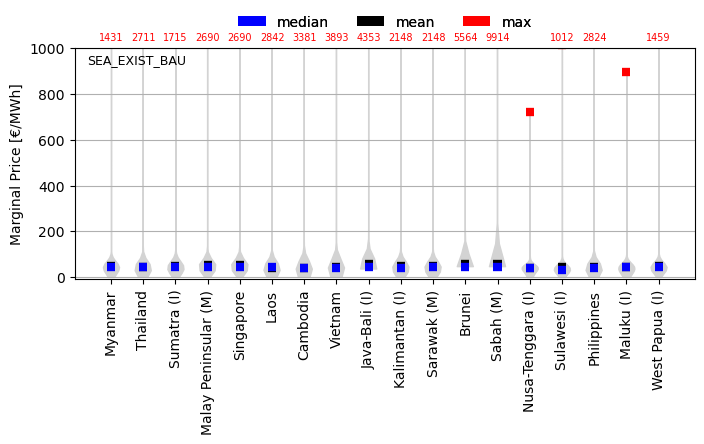

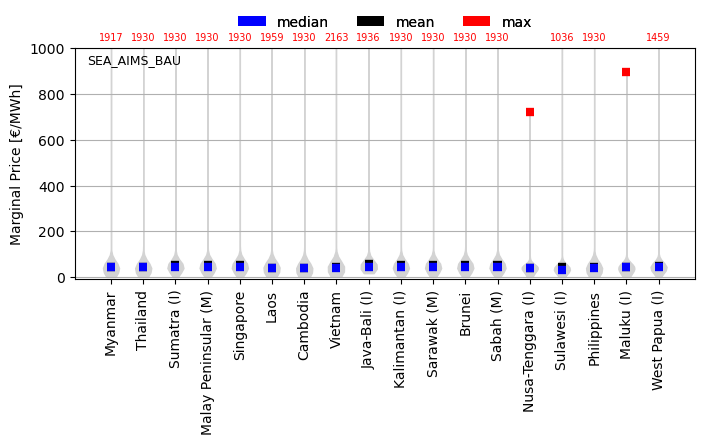

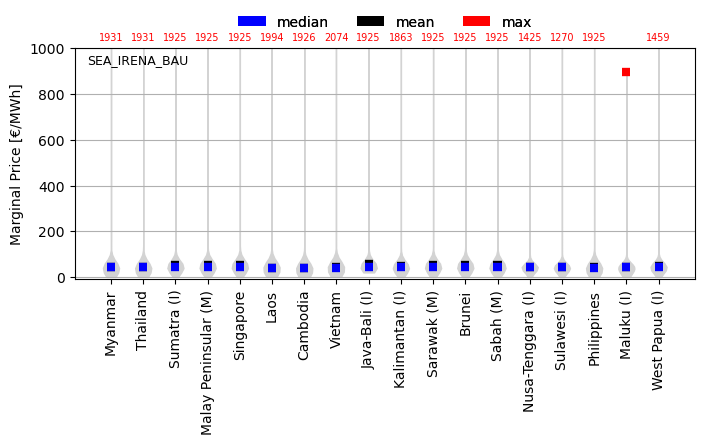

In [110]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_3H"
dec_name = "BAU"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

for scenario in scenarios:
    df = violin_comp(fn[scenario],scenario,dec_name)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


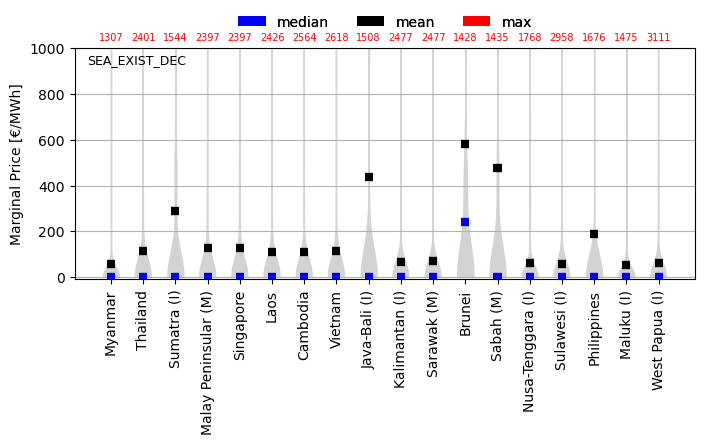

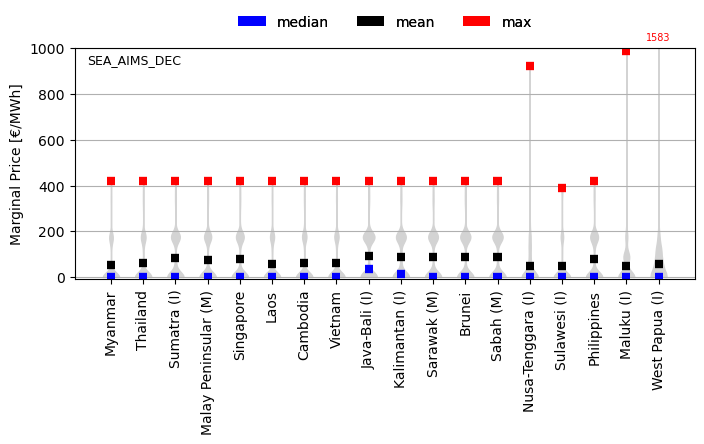

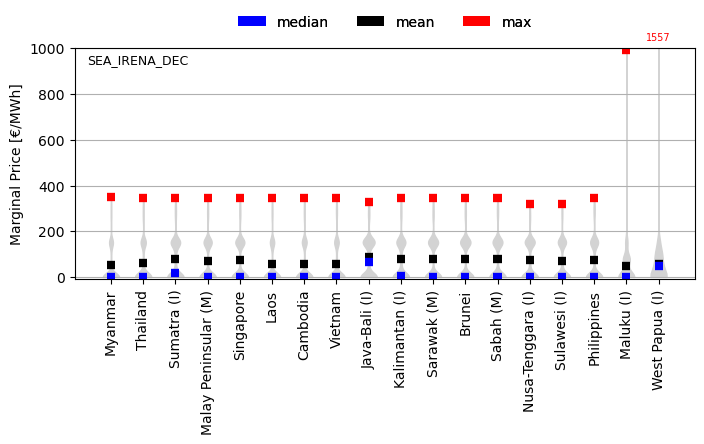

In [111]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.050092-3H"
dec_name = "DEC"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

for scenario in scenarios:
    df = violin_comp(fn[scenario],scenario,dec_name)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


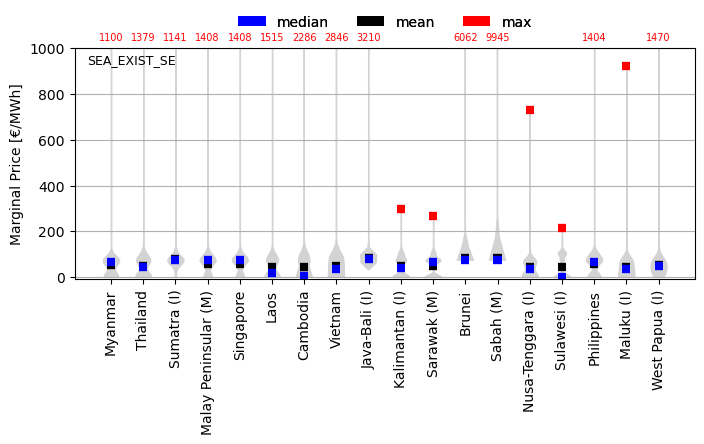

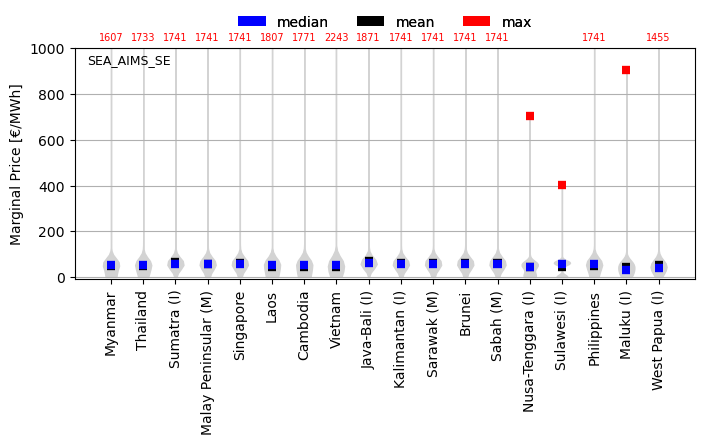

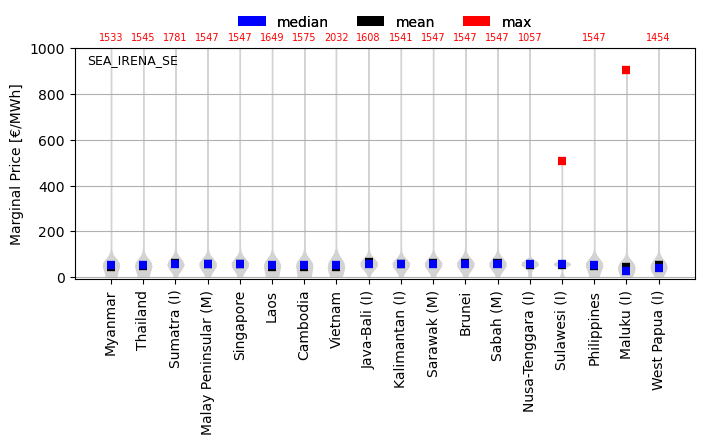

In [112]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.500924-3H"
dec_name = "SE"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

for scenario in scenarios:
    df = violin_comp(fn[scenario],scenario,dec_name)

In [74]:
country_prefered_order_cross = ['West Papua (I)', 'Maluku (I)','Philippines', 'Sulawesi (I)', 'Nusa-Tenggara (I)', 'Sabah (M)', 'Brunei', 'Kalimantan (I)', 'Sarawak (M)', 'Java-Bali (I)', 'Vietnam', 'Cambodia', 'Singapore', 'Laos', 'Sumatra (I)', 'Malay Peninsular (M)', 'Thailand', 'Myanmar']

In [75]:
len(country_prefered_order_cross)

18

In [76]:
len(country_prefered_order)

18

## Energy trade and dependency

In [19]:
def plot_cross_border(n, scenario_PyPSA, dec_name):

    country_prefered_order_cross = ['West Papua (I)', 'Maluku (I)','Philippines', 'Sulawesi (I)', 'Nusa-Tenggara (I)', 
                                    'Sabah (M)', 'Brunei', 'Kalimantan (I)', 'Sarawak (M)', 'Java-Bali (I)', 'Vietnam', 
                                    'Cambodia', 'Singapore', 'Laos', 'Sumatra (I)', 'Malay Peninsular (M)', 'Thailand', 'Myanmar']
    
    snapshot = n.snapshot_weightings.objective.unique()[0]
    
    df_all = pd.DataFrame()
    
    for l in [n.lines, n.links]:
        l["country0"] = [n.buses.country[busname] for busname in l.bus0]
        l["country1"] = [n.buses.country[busname] for busname in l.bus1]
        l_ext = l.query('country0 != country1')
        
        inter_country = union(l_ext.country0.unique(), l_ext.country1.unique())
    
        df_l = pd.DataFrame()
    
        for c in inter_country:
            l_ext_c0 = l_ext.query('country0 == @c').country1
            l_ext_c1 = l_ext.query('country1 == @c').country0
            
            if l is n.lines:
                l_ext_p0 = snapshot * n.lines_t.p0[l_ext_c0.index] / 1e6 # MWh to TWh
                l_ext_p1 = snapshot * n.lines_t.p1[l_ext_c1.index] / 1e6 # MWh to TWh
    
            if l is n.links:
                l_ext_p0 = snapshot * n.links_t.p0[l_ext_c0.index] / 1e6 # MWh to TWh
                l_ext_p1 = snapshot * n.links_t.p1[l_ext_c1.index] / 1e6 # MWh to TWh
            
            l_ext_p0_ex = l_ext_p0.clip(lower=0)
            l_ext_p0_im = l_ext_p0.clip(upper=0)
        
            l_ext_p1_ex = l_ext_p1.clip(lower=0)
            l_ext_p1_im = l_ext_p1.clip(upper=0)
        
            country_ex = [f"ex_{c}" for c in pd.concat([l_ext_c0,l_ext_c1])]
            country_im = [f"im_{c}" for c in pd.concat([l_ext_c0,l_ext_c1])]
        
            df = pd.concat([pd.DataFrame(data=[country_ex,pd.concat([l_ext_p0_ex.sum(),l_ext_p1_ex.sum()])]),
                            pd.DataFrame(data=[country_im,pd.concat([l_ext_p0_im.sum(),l_ext_p1_im.sum()])])
                           ], axis=1).T
            df = df.groupby([0]).sum().T
            df = df.rename(index={1:c})
        
            if df_l.empty:
                df_l = df
            else:
                df_l = pd.concat([df_l,df],axis=1)
    
        if df_all.empty:
            df_all = df_l
        else:
            df_all = pd.concat([df_all,df_l],axis=1)
    
    df_all = df_all.groupby(level=0, axis=1).sum()
    
    color_country_ex = {f"ex_{c}":color_country[c] for c in color_country}
    color_country_im = {f"im_{c}":color_country[c] for c in color_country}
    
    color_country_ex_im = color_country_ex | color_country_im

    fig, ax = plt.subplots(figsize=(6, 6))

    df_all = add_and_rename_countries(df_all)

    new_index_order = [c for c in country_prefered_order_cross if c in df_all.index]

    #new_index_order = [country_longname[c] for c in new_index_order]

    df_all.loc[new_index_order].plot.barh(ax=ax,stacked=True,color=[color_country_ex_im[a] for a in df_all.columns], legend=False, width=0.9)

    plt.margins(y=10)
    
    plt.grid(axis="x", zorder=0)
    #ax.set_title(f"{scenario_PyPSA}{year}")
    ax.set_xlim([-2000, 2000])
    ax.set_xlabel("(-) Import             TWh             (+) Export")
    empty_string_labels = ['']*len(range(18))
    ax.set_yticklabels(empty_string_labels)
    ax.set_ylabel("")

    new_label_order = [c for c in reversed(country_prefered_order_cross) if c in df_all.index]

    country_label = pd.DataFrame(pd.Series(color_country))
    country_label = add_and_rename_countries(country_label)
    country_label = country_label.loc[new_label_order]

    pypsa.plot.add_legend_patches(ax=ax, colors = country_label[0], labels = country_label.index,
                             legend_kw = {'loc':"center right",'bbox_to_anchor':(0, 0.499), 'frameon':False, 'ncol':1, 
                                          'labelspacing':0.8,'markerfirst':False})

    ax.set_title(f'{scenario_PyPSA}{dec_name}_2050', 
                 loc='left', 
                 x=0.02, 
                 y=0.94,
                 fontsize=9
                )

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_cross_border.svg',bbox_inches='tight')

    return df_all

In [20]:
def plot_elec_dependency(n, df_cross, scenario_PyPSA, dec_name, set_log = True):
    df = pd.DataFrame()
    
    df["export"] = df_cross.where(df_cross > 0).sum(1)
    df["import"] = -df_cross.where(df_cross < 0).sum(1)

    c = n.snapshot_weightings.objective @ n.loads_t.p.T.groupby(n.buses.country).sum().T  / 1e6 # MWh to TWh
    df["load"] = add_and_rename_countries(pd.DataFrame(c))

    for c in df.index:
        if (df.loc[c,"export"]/df.loc[c,"load"] <= 0.01) ^ (df.loc[c,"import"]/df.loc[c,"load"] <= 0.01):
            if df.loc[c,"export"]/df.loc[c,"load"] <= 0.01:
                df.loc[c,"export"] = df.loc[c,"load"]*0.01
            if df.loc[c,"import"]/df.loc[c,"load"] <= 0.01:
                df.loc[c,"import"] = df.loc[c,"load"]*0.01
            
    fig, ax = plt.subplots(figsize=(5,5))
    
    x = np.arange(0.0, 100, 1)
    ax.fill_between(x, x*0.5, x/0.5, color="lightgrey")
    ax.fill_between(x, x*0.8, x/0.8, color="silver")
    ax.fill_between(x, x*0.9999, x/0.9999, color="grey")
    
    ax.scatter(df["export"]/df["load"],df["import"]/df["load"], color="tab:orange")
    
    #ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black")
    #ax.plot([0, 1], [0, 1.2], transform=ax.transAxes)
    #ax.plot([0, 1], [0, 0.8], transform=ax.transAxes)
    
    ax.axvline(x=1, color="black")
    ax.axhline(y=1, color="black")
    
    ax.set_xlabel("Total Export Relative to Internal Demand [%]")
    ax.set_ylabel("Total Import Relative to Internal Demand [%]")
    
    if set_log:
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim(0.01,10)
        ax.set_ylim(0.01,10)
    
    else:
        ax.set_xlim(0,8)
        ax.set_ylim(0,8)
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
    ax.grid(b=True, which='major', color='grey', linestyle='-', linewidth=0.5)
    ax.grid(b=True, which='minor', color='grey', linestyle='--', linewidth=0.5)
    
    for idx, row in df.iterrows():
        if idx in ["Thailand","Brunei", "Java-Bali (I)"]:
            alignment = 'left'
        elif idx in ["Sarawak (M)","Singapore"]:
            alignment = 'right'
        else:
            alignment = 'center'
        plt.annotate(text=idx, xy=(row["export"]/row["load"],row["import"]/row["load"]), horizontalalignment=alignment, color="black", fontsize=9)

    plt.annotate(text="Trade Balance Equilibrium", xy=(0.03,0.015), horizontalalignment="center", color="black", fontsize=9, rotation=45)
    plt.annotate(text="Internal Demand", xy=(0.9,0.015), horizontalalignment="center", color="grey", fontsize=9, rotation=90)
    plt.annotate(text="Internal Demand", xy=(0.03,1.1), horizontalalignment="center", color="grey", fontsize=9)

    independent_country = []
    
    for c in df.index:
        if df.loc[c,"export"] == 0 and df.loc[c,"import"] == 0:
            independent_country += [c]
    
    legend_bus = {"sizes":[7e-10] * len(independent_country),
                  "labels":independent_country
                 }

    pypsa.plot.add_legend_circles(ax=ax, sizes = legend_bus["sizes"], labels = legend_bus["labels"],
                                  patch_kw = {'color':"tab:orange"},
                                  legend_kw = {'loc':"center left",'bbox_to_anchor':(1.005, 0.5), 'handlelength':0.5,
                                               'frameon':False, 'title':"Independent \nCountries/Subregion", 'fontsize':9,
                                              'title_fontproperties':{'weight':'bold'}})

    ax.set_title(f'{scenario_PyPSA}{dec_name}_2050', 
                 loc='left', 
                 x=1.02, 
                 y=0.94,
                 fontsize=9
                )

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_elec_dependency.svg',bbox_inches='tight')

    return df

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


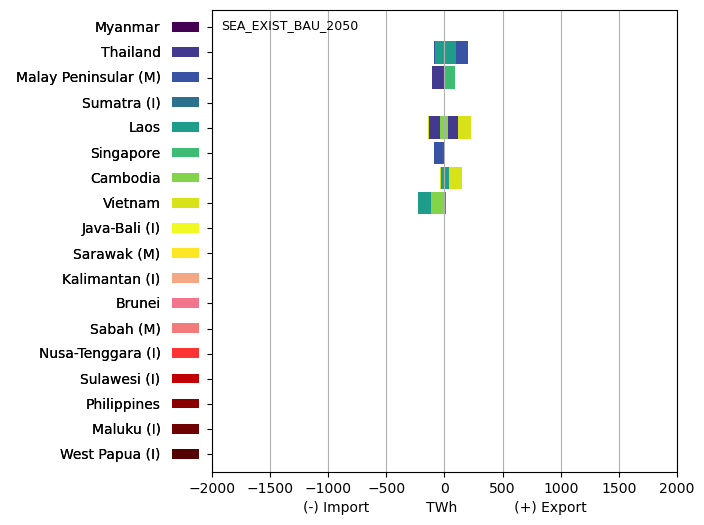

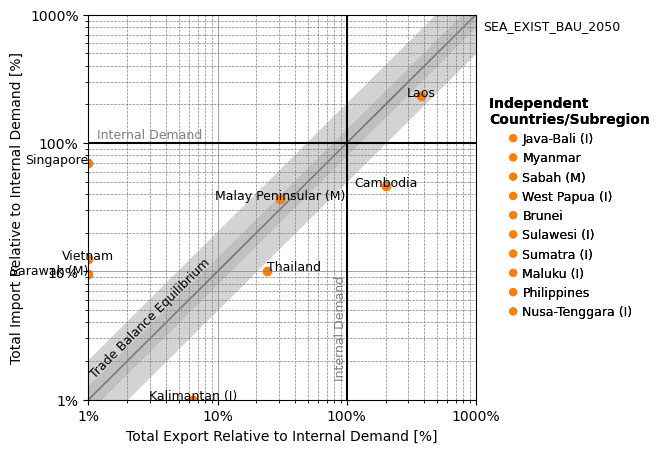

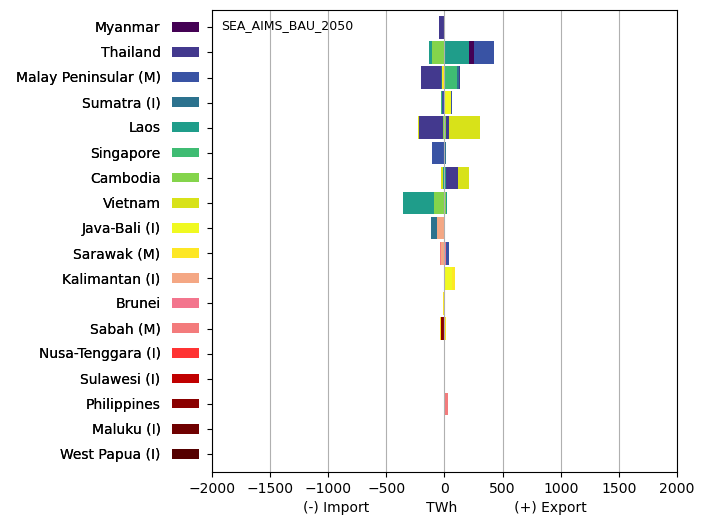

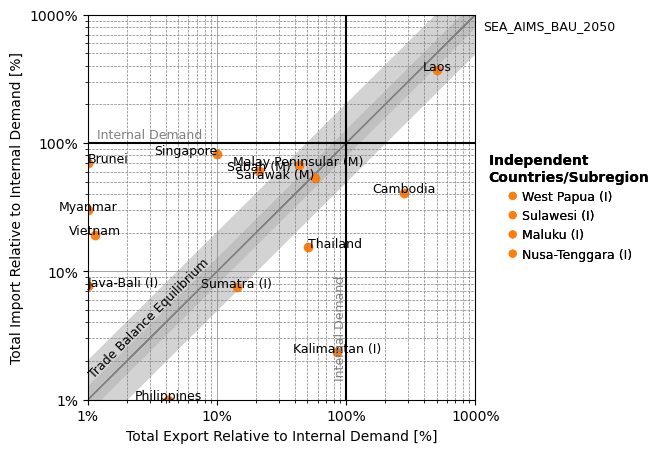

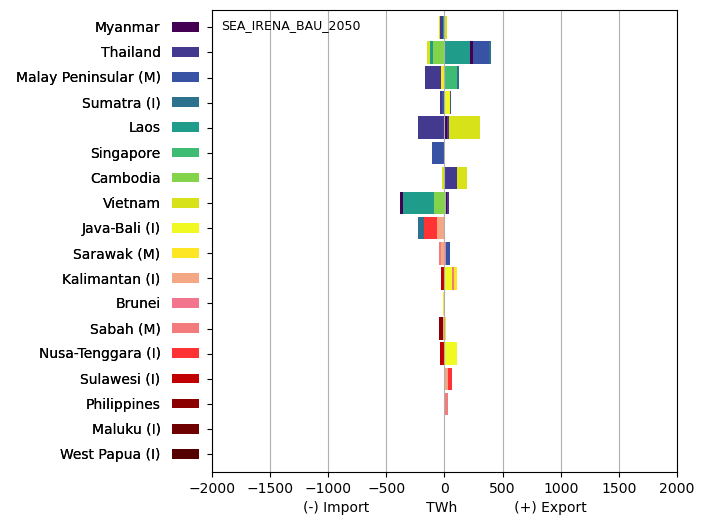

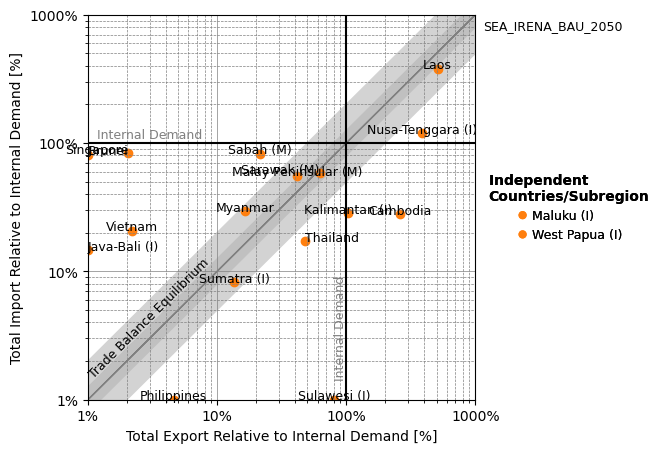

In [21]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_3H"
dec_name = "BAU"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

df_cross = {}
df_depend = {}

for scenario in scenarios:
    df_cross[scenario] = plot_cross_border(fn[scenario],scenario,dec_name)
    df_depend[scenario] = plot_elec_dependency(fn[scenario], df_cross[scenario],scenario,dec_name)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


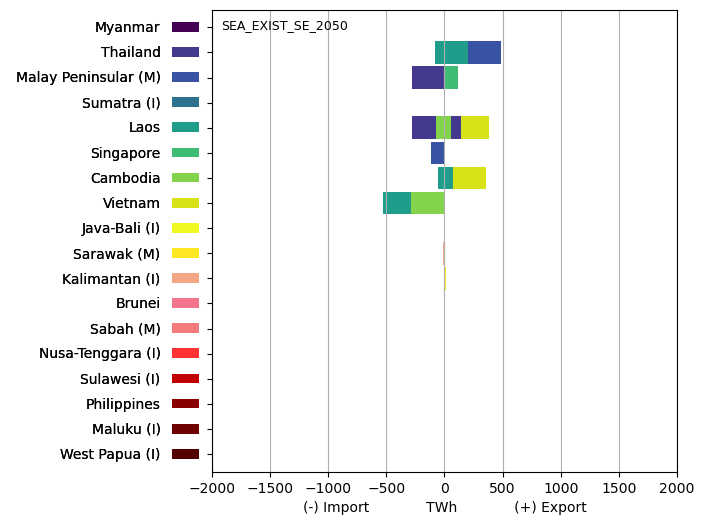

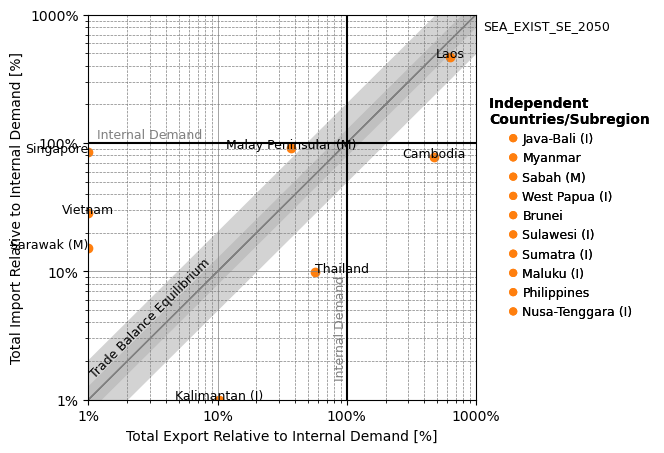

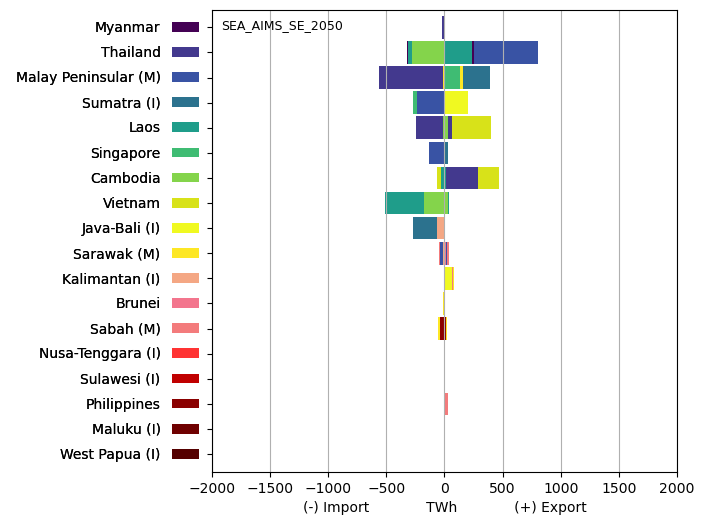

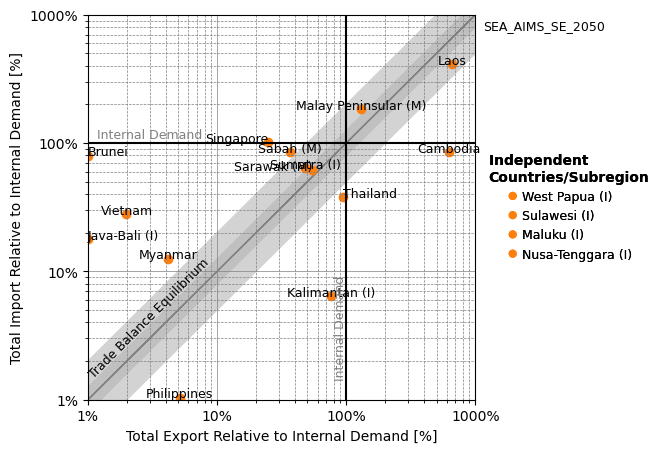

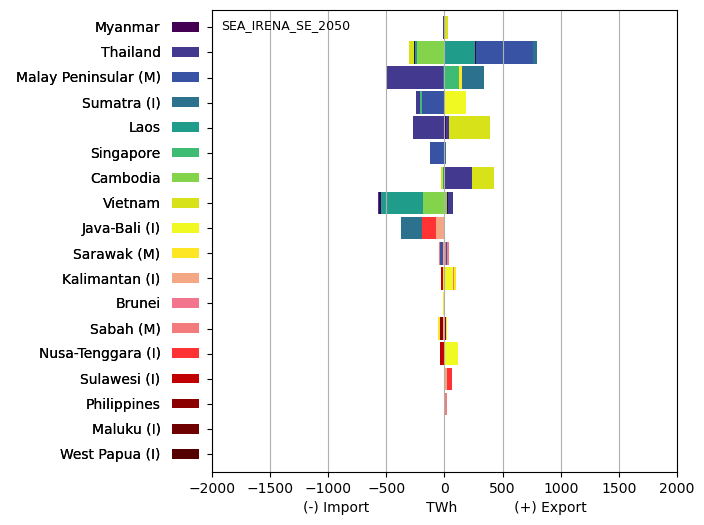

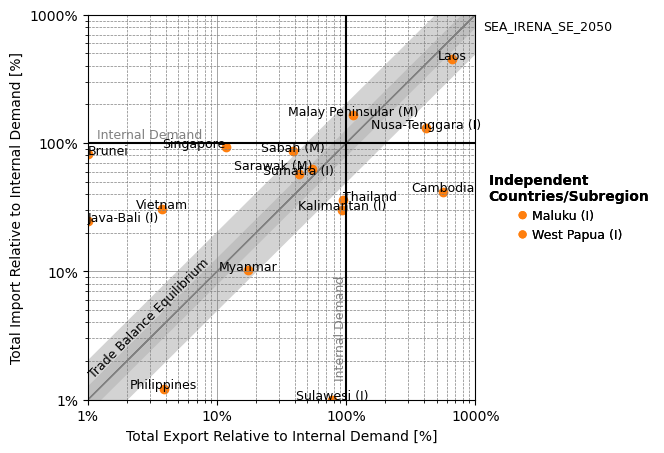

In [22]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.500924-3H"
dec_name = "SE"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

df_cross = {}
df_depend = {}

for scenario in scenarios:
    df_cross[scenario] = plot_cross_border(fn[scenario],scenario,dec_name)
    df_depend[scenario] = plot_elec_dependency(fn[scenario], df_cross[scenario],scenario,dec_name)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


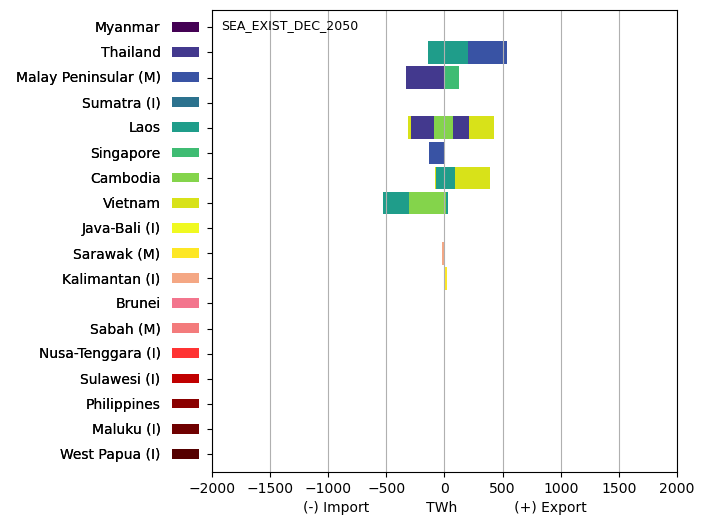

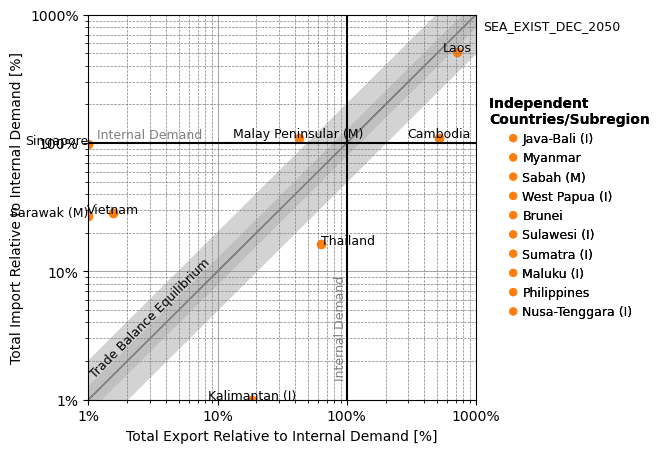

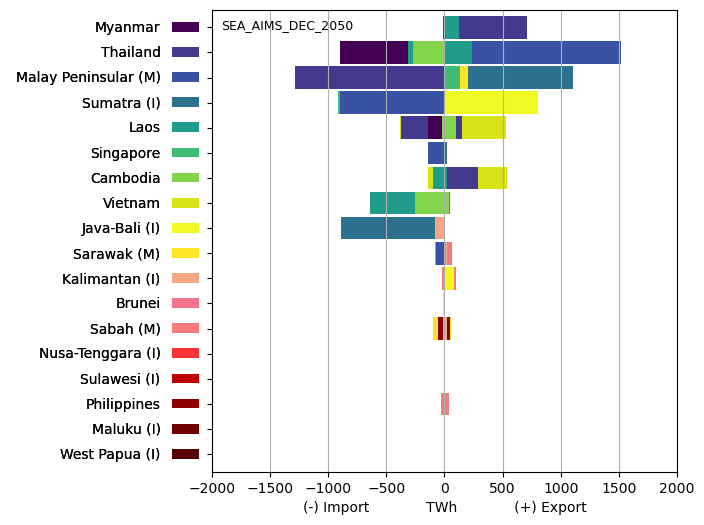

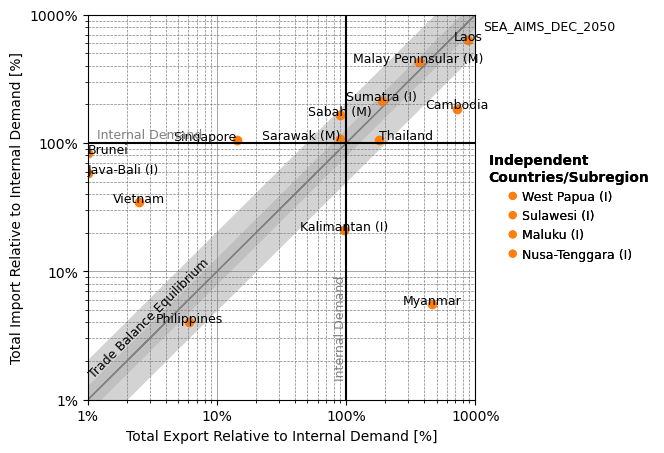

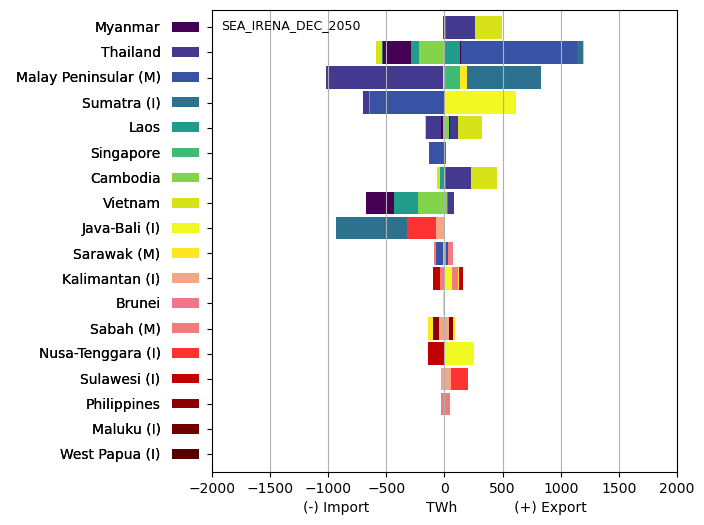

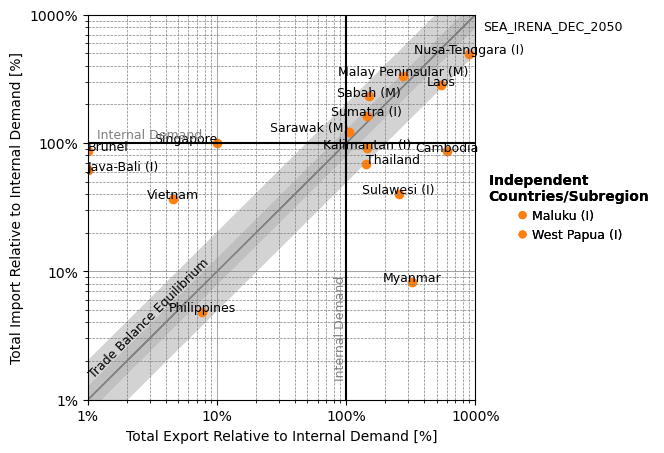

In [23]:
scenarios = ["SEA_EXIST_", "SEA_AIMS_", "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.050092-3H"
dec_name = "DEC"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios}

df_cross = {}
df_depend = {}

for scenario in scenarios:
    df_cross[scenario] = plot_cross_border(fn[scenario],scenario,dec_name)
    df_depend[scenario] = plot_elec_dependency(fn[scenario], df_cross[scenario],scenario,dec_name)

In [98]:
df_depend["SEA_AIMS_"]["ex/load"] = round(df_depend["SEA_AIMS_"]["export"]/df_depend["SEA_AIMS_"]["load"] * 100,1)
df_depend["SEA_AIMS_"]["im/load"] = round(df_depend["SEA_AIMS_"]["import"]/df_depend["SEA_AIMS_"]["load"] * 100,1)
df_depend["SEA_AIMS_"]

,export,import,load,ex/load,im/load
Countries,,,,,
Kalimantan (I),103.446547,22.678181,108.024733,95.8,21.0
Myanmar,710.060122,8.523514,153.453000,462.7,5.6
Sabah (M),53.995967,98.953489,60.234157,89.6,164.3
Vietnam,45.820309,636.801556,1840.882000,2.5,34.6
Cambodia,541.943975,140.624324,75.668000,716.2,185.8
Laos,532.521804,380.873427,60.275262,883.5,631.9
Thailand,1517.738639,899.122546,846.695846,179.3,106.2
Singapore,18.740335,138.749458,131.909000,14.2,105.2
Sarawak (M),66.718544,79.165022,74.042450,90.1,106.9


## Internal Grid Expansion

In [13]:
def calculate_grid_expansion(fn, years):
    n = fn[2020]
    #lines
    line = n.lines
    line["country0"] = [n.buses.country[busname] for busname in line.bus0]
    line["country1"] = [n.buses.country[busname] for busname in line.bus1]
    
    df_line = pd.DataFrame(index=n.buses.country.unique())
    df_line["internal_OSM"] = [(line.query('country0 == @c & country1 == @c').s_nom * line.query('country0 == @c & country1 == @c').length
                      ).sum()  for c in df_line.index]
    df_line[f"interregional_OSM"] = [(line.query('country0 == @c & country1 != @c').s_nom * line.query('country0 == @c & country1 != @c').length).sum()/2
                                     + (line.query('country0 != @c & country1 == @c').s_nom * line.query('country0 != @c & country1 == @c').length).sum()/2 for c in df_line.index]
        
    for year in years:
        line = fn[year].lines
        line["country0"] = [n.buses.country[busname] for busname in line.bus0]
        line["country1"] = [n.buses.country[busname] for busname in line.bus1]
        df_line[f"internal_{year}"] = [(line.query('country0 == @c & country1 == @c').s_nom_opt * line.query('country0 == @c & country1 == @c').length).sum()  for c in df_line.index]
        df_line[f"interregional_{year}"] = [(line.query('country0 == @c & country1 != @c').s_nom_opt * line.query('country0 == @c & country1 != @c').length).sum()/2
                                             + (line.query('country0 != @c & country1 == @c').s_nom_opt * line.query('country0 != @c & country1 == @c').length).sum()/2 for c in df_line.index]

    #links
    link = n.links
    link["country0"] = [n.buses.country[busname] for busname in link.bus0]
    link["country1"] = [n.buses.country[busname] for busname in link.bus1]

    df_link = pd.DataFrame(index=n.buses.country.unique())
    df_link["internal_OSM"] = [(link.query('country0 == @c & country1 == @c & carrier == "DC"').p_nom * link.query('country0 == @c & country1 == @c & carrier == "DC"').length).sum()  for c in df_link.index]
    df_link[f"interregional_OSM"] = [(link.query('country0 == @c & country1 != @c & carrier == "DC"').p_nom * link.query('country0 == @c & country1 != @c & carrier == "DC"').length).sum()/2
                                      + (link.query('country0 != @c & country1 == @c & carrier == "DC"').p_nom * link.query('country0 != @c & country1 == @c & carrier == "DC"').length).sum()/2 for c in df_link.index]
    
    for year in years:
        link = fn[year].links
        link["country0"] = [n.buses.country[busname] for busname in link.bus0]
        link["country1"] = [n.buses.country[busname] for busname in link.bus1]
        df_link[f"internal_{year}"] = [(link.query('country0 == @c & country1 == @c & carrier == "DC"').p_nom_opt * link.query('country0 == @c & country1 == @c & carrier == "DC"').length).sum()  for c in df_link.index]
        df_link[f"interregional_{year}"] = [(link.query('country0 == @c & country1 != @c & carrier == "DC"').p_nom_opt * link.query('country0 == @c & country1 != @c & carrier == "DC"').length).sum()/2
                                             + (link.query('country0 != @c & country1 == @c & carrier == "DC"').p_nom_opt * link.query('country0 != @c & country1 == @c & carrier == "DC"').length).sum()/2 for c in df_link.index]
    
    df_all = pd.concat([df_line,df_link])
    df_all = df_all.groupby(level=0, axis=1).sum()
    df_all = df_all.groupby(level=0, axis=0).sum()

    # MVAkm to TVAkm
    df_all = df_all/1e6

    df_all = add_and_rename_countries(df_all)

    return df_all

def calculate_grid_cost(fn, years):
    n = fn[2020]
    #lines
    line = n.lines
    line["country0"] = [n.buses.country[busname] for busname in line.bus0]
    line["country1"] = [n.buses.country[busname] for busname in line.bus1]
    
    df_line = pd.DataFrame(index=n.buses.country.unique())
    df_line["internal_OSM"] = [(line.query('country0 == @c & country1 == @c').s_nom * line.query('country0 == @c & country1 == @c').capital_cost
                      ).sum()  for c in df_line.index]
    df_line[f"interregional_OSM"] = [(line.query('country0 == @c & country1 != @c').s_nom * line.query('country0 == @c & country1 != @c').capital_cost).sum()/2
                                     + (line.query('country0 != @c & country1 == @c').s_nom * line.query('country0 != @c & country1 == @c').capital_cost).sum()/2 for c in df_line.index]
        
    for year in years:
        line = fn[year].lines
        line["country0"] = [n.buses.country[busname] for busname in line.bus0]
        line["country1"] = [n.buses.country[busname] for busname in line.bus1]
        df_line[f"internal_{year}"] = [(line.query('country0 == @c & country1 == @c').s_nom_opt * line.query('country0 == @c & country1 == @c').capital_cost).sum()  for c in df_line.index]
        df_line[f"interregional_{year}"] = [(line.query('country0 == @c & country1 != @c').s_nom_opt * line.query('country0 == @c & country1 != @c').capital_cost).sum()/2
                                             + (line.query('country0 != @c & country1 == @c').s_nom_opt * line.query('country0 != @c & country1 == @c').capital_cost).sum()/2 for c in df_line.index]

    #links
    link = n.links
    link["country0"] = [n.buses.country[busname] for busname in link.bus0]
    link["country1"] = [n.buses.country[busname] for busname in link.bus1]

    df_link = pd.DataFrame(index=n.buses.country.unique())
    df_link["internal_OSM"] = [(link.query('country0 == @c & country1 == @c & carrier == "DC"').p_nom * link.query('country0 == @c & country1 == @c & carrier == "DC"').capital_cost).sum()  for c in df_link.index]
    df_link[f"interregional_OSM"] = [(link.query('country0 == @c & country1 != @c & carrier == "DC"').p_nom * link.query('country0 == @c & country1 != @c & carrier == "DC"').capital_cost).sum()/2
                                      + (link.query('country0 != @c & country1 == @c & carrier == "DC"').p_nom * link.query('country0 != @c & country1 == @c & carrier == "DC"').capital_cost).sum()/2 for c in df_link.index]
    
    for year in years:
        link = fn[year].links
        link["country0"] = [n.buses.country[busname] for busname in link.bus0]
        link["country1"] = [n.buses.country[busname] for busname in link.bus1]
        df_link[f"internal_{year}"] = [(link.query('country0 == @c & country1 == @c & carrier == "DC"').p_nom_opt * link.query('country0 == @c & country1 == @c & carrier == "DC"').capital_cost).sum()  for c in df_link.index]
        df_link[f"interregional_{year}"] = [(link.query('country0 == @c & country1 != @c & carrier == "DC"').p_nom_opt * link.query('country0 == @c & country1 != @c & carrier == "DC"').capital_cost).sum()/2
                                             + (link.query('country0 != @c & country1 == @c & carrier == "DC"').p_nom_opt * link.query('country0 != @c & country1 == @c & carrier == "DC"').capital_cost).sum()/2 for c in df_link.index]
    
    df_all = pd.concat([df_line,df_link])
    df_all = df_all.groupby(level=0, axis=1).sum()
    df_all = df_all.groupby(level=0, axis=0).sum()

    # € to bil€
    df_all = df_all/1e9

    df_all = add_and_rename_countries(df_all)

    return df_all

def plot_grid_expansion(fn, scenario_PyPSA, dec_name):
    years = [2020,2025,2030,2035,2040,2045,2050]

    df_all = calculate_grid_expansion(fn,years)

    fig, ax = plt.subplots(figsize=(6, 6))
    
    new_index_order = [c for c in country_prefered_order if c in df_all.index]

    df_all = df_all.loc[new_index_order,:]
    df_all.loc[df_all.T.sum() == 0,"Single Nodes"] = 10000

    color_year_interregional = {'interregional_2050':"#0000ff", 
            'interregional_2045':"#2424ff", 
            'interregional_2040':"#4343ff", 
            'interregional_2035':"#6565ff",
            'interregional_2030':"#8989ff",
            'interregional_2025':"#afafff", 
            'interregional_2020':"#d6d6ff", 
            'interregional_OSM':"#ececff"
            }

    for column in color_year_interregional.keys():
        (df_all.loc[:,column] + df_all.loc[:,'internal_2050']).plot.barh(ax=ax,color=color_year_interregional[column],width= 0.9)

    color_year_internal = {'internal_2050':"#000000", 
            'internal_2045':"#242424", 
            'internal_2040':"#434343", 
            'internal_2035':"#656565",
            'internal_2030':"#898989",
            'internal_2025':"#afafaf", 
            'internal_2020':"#d6d6d6", 
            'internal_OSM':"#ececec"
            }
    for column in color_year_internal.keys():
        df_all.loc[:,column].plot.barh(ax=ax,color=color_year_internal[column],width= 0.9)

    df_all.loc[:,"Single Nodes"].plot.barh(ax=ax,color='none',edgecolor="red",width= 1,linewidth=0,hatch= "///")
    
    ax.set_xlabel('TVA km')
    ax.set_ylabel('')
    ax.set_xlim([0, 500])
    #ax.set_xlim([0, 2])
    plt.grid(axis="x", zorder=0)

    df_color = pd.Series({key.replace("interregional_", ""): value for key, value in color_year_interregional.items()})

    pypsa.plot.add_legend_patches(ax=ax, colors = df_color, labels = df_color.index,
                                 legend_kw = {'loc':"center left",'bbox_to_anchor':(1, 0.75), 'frameon':False, 'ncol':1, 'title':"Interregional\nTransmission in year", 
                                              'title_fontproperties':{'weight':'bold'}})

    df_color = pd.Series({key.replace("internal_", ""): value for key, value in color_year_internal.items()})

    pypsa.plot.add_legend_patches(ax=ax, colors = df_color, labels = df_color.index,
                                 legend_kw = {'loc':"center left",'bbox_to_anchor':(1, 0.3), 'frameon':False, 'ncol':1, 'title':"Internal\nTransmission in year", 
                                              'title_fontproperties':{'weight':'bold'}})

    pypsa.plot.add_legend_patches(ax=ax, colors = 'none', labels = "Single Nodes",
                                  patch_kw = {'hatch':"///", 'edgecolor':"red",'lw':1},
                                  legend_kw = {'loc':"center left",'bbox_to_anchor':(1, 0.07), 'frameon':False, 'title':" ", 
                                              'title_fontproperties':{'weight':'bold'}})

    ax.set_title(f'{scenario_PyPSA}{dec_name}', 
                 loc='right', 
                 x=0.98, 
                 y=0.94,
                 fontsize=9
                )

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_internal_grid.svg',bbox_inches='tight')

    return df_all

In [96]:
scenario_PyPSAs = ["SEA_EXIST_","SEA_AIMS_","SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_3H"
dec_name = "BAU"

years = [2020,2050]

for scenario_PyPSA in scenario_PyPSAs:
    fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA}{year}/networks/{network_name}.nc") for year in years}
    
    #df = calculate_grid_expansion(fn, years)
    #print(f"for {scenario_PyPSA}:")
    #print(f"Internal 2050: {df['internal_2050'].sum()} TVAkm")
    #print(f"Regional 2050: {df['interregional_2050'].sum()} TVAkm")

    df_cost = calculate_grid_cost(fn, years)
    print(f"for {scenario_PyPSA}:")
    internal = df_cost['internal_2050'].sum()
    regional = df_cost['interregional_2050'].sum()
    print(f"Internal 2050: {round(internal,1)} Bil€/a")
    print(f"Regional 2050: {round(regional,1)} Bil€/a")
    print(f"total: {round(internal + regional,1)}")

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


for SEA_EXIST_:
Internal 2050: 14.9 Bil€/a
Regional 2050: 1.9 Bil€/a
total: 16.8


INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


for SEA_AIMS_:
Internal 2050: 14.5 Bil€/a
Regional 2050: 4.0 Bil€/a
total: 18.4


INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


for SEA_IRENA_:
Internal 2050: 15.4 Bil€/a
Regional 2050: 5.4 Bil€/a
total: 20.8


In [116]:
scenario_PyPSAs = ["SEA_EXIST_","SEA_AIMS_","SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = {2050:"elec_s_200_ec_lcopt_Co2L0.050092-3H",
                2020:"elec_s_200_ec_lcopt_Co2L1-3H"}
dec_name = "DEC"

years = [2020,2050]

for scenario_PyPSA in scenario_PyPSAs:
    fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA}{year}/networks/{network_name[year]}.nc") for year in years}
    
    df = calculate_grid_expansion(fn, years)
    print(f"for {scenario_PyPSA}:")
    print(f"Internal 2050: {df['internal_2050'].sum()} TVAkm")
    print(f"Regional 2050: {df['interregional_2050'].sum()} TVAkm")

    df_cost = calculate_grid_cost(fn, years)
    #print(f"for {scenario_PyPSA}:")
    internal = df_cost['internal_2050'].sum()
    regional = df_cost['interregional_2050'].sum()
    print(f"Internal 2050: {round(internal,1)} Bil€/a")
    print(f"Regional 2050: {round(regional,1)} Bil€/a")
    print(f"total: {round(internal + regional,1)}")

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


for SEA_EXIST_:
Internal 2050: 649.777451131403 TVAkm
Regional 2050: 85.56137702861975 TVAkm
Internal 2050: 27.7 Bil€/a
Regional 2050: 3.7 Bil€/a
total: 31.4


INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


for SEA_AIMS_:
Internal 2050: 1127.1913345359753 TVAkm
Regional 2050: 252.2363803008722 TVAkm
Internal 2050: 47.8 Bil€/a
Regional 2050: 15.9 Bil€/a
total: 63.8


INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


for SEA_IRENA_:
Internal 2050: 990.7198206781703 TVAkm
Regional 2050: 256.30709711392575 TVAkm
Internal 2050: 42.9 Bil€/a
Regional 2050: 18.0 Bil€/a
total: 60.9


INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.779298-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.583549-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.412754-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.266913-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.146026-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators

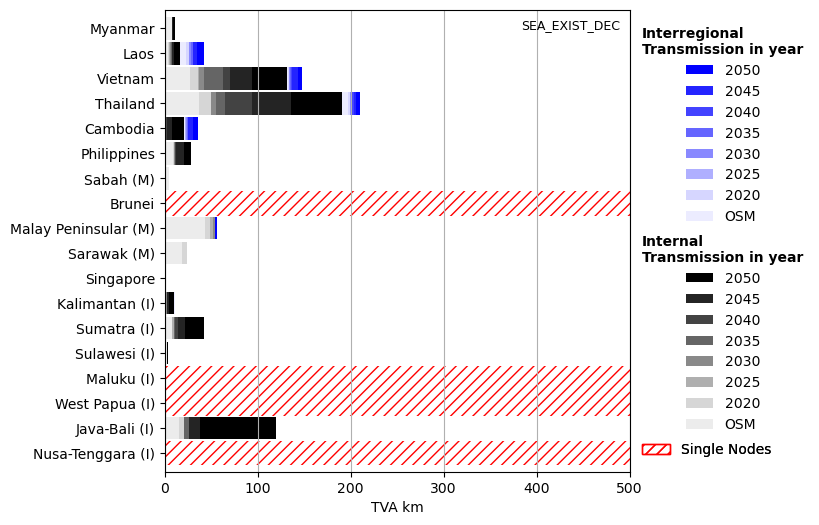

In [14]:
SE_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.916821-3H",
             2030:"Co2L0.833641-3H",
             2035:"Co2L0.750462-3H",
             2040:"Co2L0.667283-3H",
             2045:"Co2L0.584104-3H",
             2050:"Co2L0.500924-3H"
            }
DEC_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.779298-3H",
             2030:"Co2L0.583549-3H",
             2035:"Co2L0.412754-3H",
             2040:"Co2L0.266913-3H",
             2045:"Co2L0.146026-3H",
             2050:"Co2L0.050092-3H"
            }

scenario_PyPSA = "SEA_EXIST_" # ["SEA_AIMS_", , "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_"
co2_share = DEC_co2_share
dec_name = "DEC"

years = [2020,2025,2030,2035,2040,2045,2050]

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA}{year}/networks/{network_name}{co2_share[year]}.nc") for year in years}

df = plot_grid_expansion(fn, scenario_PyPSA, dec_name)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.779298-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.583549-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.412754-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.266913-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.146026-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators

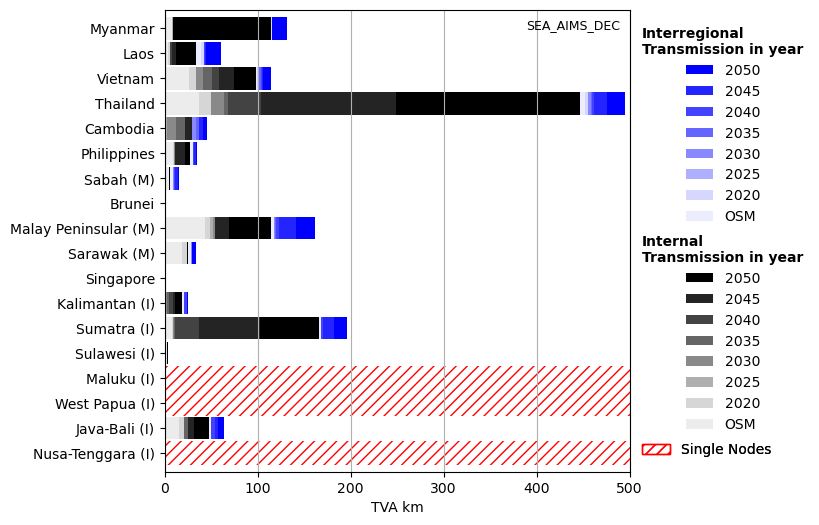

In [15]:
SE_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.916821-3H",
             2030:"Co2L0.833641-3H",
             2035:"Co2L0.750462-3H",
             2040:"Co2L0.667283-3H",
             2045:"Co2L0.584104-3H",
             2050:"Co2L0.500924-3H"
            }
DEC_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.779298-3H",
             2030:"Co2L0.583549-3H",
             2035:"Co2L0.412754-3H",
             2040:"Co2L0.266913-3H",
             2045:"Co2L0.146026-3H",
             2050:"Co2L0.050092-3H"
            }

scenario_PyPSA = "SEA_AIMS_" # ["SEA_EXIST_", , "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_"
co2_share = DEC_co2_share
dec_name = "DEC"

years = [2020,2025,2030,2035,2040,2045,2050]

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA}{year}/networks/{network_name}{co2_share[year]}.nc") for year in years}

df = plot_grid_expansion(fn, scenario_PyPSA, dec_name)

In [11]:
df["internal_2050"] + df["interregional_2050"]

Countries
Nusa-Tenggara (I)         0.000000
Java-Bali (I)            63.210817
West Papua (I)            0.000000
Maluku (I)                0.000000
Sulawesi (I)              3.227610
Sumatra (I)             195.460650
Kalimantan (I)           24.855443
Singapore                 1.153309
Sarawak (M)              33.261222
Malay Peninsular (M)    162.004617
Brunei                    0.061633
Sabah (M)                15.669735
Philippines              34.236880
Cambodia                 45.255927
Thailand                495.111314
Vietnam                 114.240923
Laos                     60.704584
Myanmar                 130.973051
dtype: float64

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.779298-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.583549-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.412754-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.266913-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.146026-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators

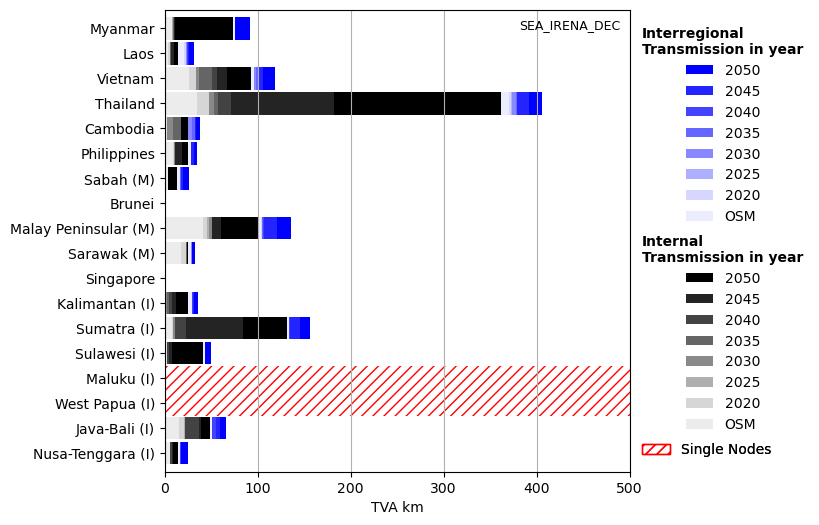

In [16]:
SE_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.916821-3H",
             2030:"Co2L0.833641-3H",
             2035:"Co2L0.750462-3H",
             2040:"Co2L0.667283-3H",
             2045:"Co2L0.584104-3H",
             2050:"Co2L0.500924-3H"
            }
DEC_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.779298-3H",
             2030:"Co2L0.583549-3H",
             2035:"Co2L0.412754-3H",
             2040:"Co2L0.266913-3H",
             2045:"Co2L0.146026-3H",
             2050:"Co2L0.050092-3H"
            }

scenario_PyPSA = "SEA_IRENA_" # ["SEA_EXIST_", , "SEA_IRENA_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_"
co2_share = DEC_co2_share
dec_name = "DEC"

years = [2020,2025,2030,2035,2040,2045,2050]

fn = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA}{year}/networks/{network_name}{co2_share[year]}.nc") for year in years}

df = plot_grid_expansion(fn, scenario_PyPSA, dec_name)

In [9]:
df["internal_2050"] + df["interregional_2050"]

1247.026917792096

In [9]:
df.sum()

internal_2020           215.815553
internal_2025           217.033510
internal_2030           241.327705
internal_2035           273.135214
internal_2040           317.772617
internal_2045           546.419047
internal_2050           990.719821
internal_OSM            179.084361
interregional_2020       53.505363
interregional_2025       55.590803
interregional_2030       67.984902
interregional_2035       75.376990
interregional_2040       82.128545
interregional_2045      141.376284
interregional_2050      256.307097
interregional_OSM        47.791110
Single Nodes          20000.000000
dtype: float64

## Cross Border Grid capacity

In [56]:
def cross_border_capacity(n, compare = "cap_length"):
    df_all = pd.DataFrame()
    
    for l in [n.lines, n.links]:
        l["country0"] = [country_longname[n.buses.country[busname]] for busname in l.bus0]
        l["country1"] = [country_longname[n.buses.country[busname]] for busname in l.bus1]
        l_ext = l.query('country0 != country1')
    
        l_ext["country_link"] = [[l_ext.country0[i], l_ext.country1[i]] for i in l_ext.index]
        
        inter_country = union(l_ext.country0.unique(), l_ext.country1.unique())
    
        for i in l_ext.index:
            l_ext.country_link[i] = [c for c in country_prefered_order if c in l_ext.country_link[i]]
            l_ext.country0[i] = l_ext.country_link[i][0]
            l_ext.country1[i] = l_ext.country_link[i][1]

        if l is n.lines:
            l_ext["cap_max"] = pd.DataFrame({ 'a' : abs(n.lines_t.p0[l_ext.index].max()), 'b' : abs(n.lines_t.p0[l_ext.index].min()) }).max(axis=1)
        if l is n.links:
            l_ext["cap_max"] = pd.DataFrame({ 'a' : abs(n.links_t.p0[l_ext.index].max()), 'b' : abs(n.links_t.p0[l_ext.index].min()) }).max(axis=1)
    
        l_ext = l_ext.set_index("country1")
        l_ext.country1 = l_ext.index
    
        new_index_order = [c for c in reversed(country_prefered_order) if c in l_ext.index]

        if l is n.lines:
            line_ext = l_ext.loc[new_index_order,:]
        if l is n.links:
            link_ext = l_ext.loc[new_index_order,:]
    
    if compare == "cap_length":
        line_ext["cap_length"] = line_ext.s_nom_opt * line_ext.length
        df_line = line_ext.groupby(["country0","country1"]).cap_length.sum()
        link_ext["cap_length"] = link_ext.p_nom_opt * link_ext.length
        df_all = pd.concat([df_line,link_ext.groupby(["country0","country1"]).cap_length.sum()])

        #MVAkm to TVAkm
        df_all = df_all/1e6

    if compare == "cap":
        df_line = line_ext.groupby(["country0","country1"]).s_nom_opt.sum()
        df_all = pd.concat([df_line,link_ext.groupby(["country0","country1"]).p_nom_opt.sum()])

        #MVA to GW
        df_all = df_all/1e3

    if compare == "cap_max":
        df_line = line_ext.groupby(["country0","country1"]).cap_max.sum()
        df_all = pd.concat([df_line,link_ext.groupby(["country0","country1"]).cap_max.sum()])

        #MVA to GW
        df_all = df_all/1e3
    
    df_all = df_all.groupby(level=(0,1)).sum()

    new_index_order = [c for c in reversed(country_prefered_order) if c in df_all.index]
    df_all = df_all[new_index_order]
    
    df = pd.DataFrame(df_all)
    df["Project"] = df.index.get_level_values(0) + " - " + df.index.get_level_values(1)
    df = df.set_index("Project")
    df = df.rename(columns={ df.columns[0]: "output" })

    df = round(df,2)

    return df

### Compare weather year

In [70]:
folder_name = "pypsa-earth"
network_names = "elec_s_200_ec_lcopt_Co2L0.050092-3H"
dec_name = "DEC"

year = 2050

scenarios = ["SEA_EXIST_","SEA_ERA5_2013_EXIST_","SEA_ERA5_2011_EXIST_"]
fn_exist = {scenario_PyPSA:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names}.nc") for scenario_PyPSA in scenarios}

scenarios= ["SEA_AIMS_","SEA_ERA5_2013_AIMS_","SEA_ERA5_2011_AIMS_"]
fn_aims = {scenario_PyPSA:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names}.nc") for scenario_PyPSA in scenarios}

scenarios = ["SEA_IRENA_","SEA_ERA5_2013_IRENA_","SEA_ERA5_2011_IRENA_"]
fn_irena = {scenario_PyPSA:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names}.nc") for scenario_PyPSA in scenarios}

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, gen

In [74]:
def get_deviation(df_base):
    columns = df_base.columns

    df =df_base.copy(deep=True)
    
    df["mean"] = df.loc[:,columns].T.mean().T
    df["max"] = df.loc[:,columns].T.max().T
    df["min"] = df.loc[:,columns].T.min().T
    df["mean-max"] = abs(df["mean"] - df["max"])
    df["mean-min"] = abs(df["mean"] - df["min"])
    
    return round(df["mean"],2), round(df.loc[:,["mean-max","mean-min"]].T.max().T/df["mean"] * 100,2)

df_all = pd.DataFrame()

fn_choice = fn_irena

for name, fn in fn_choice.items():
    df = cross_border_capacity(fn)
    df = df.rename(columns={"output":name})
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df], axis=1)

#df_all["max"] = df_all.T.max().T
df_all.sum()

SEA_IRENA_              256.32
SEA_ERA5_2013_IRENA_    301.94
SEA_ERA5_2011_IRENA_    281.65
dtype: float64

In [77]:
df_all.to_csv("Tables/interconnection_cap_weather-years.csv")

In [76]:
df_all.style.highlight_max(color = 'yellow', axis = 1)

,SEA_IRENA_,SEA_ERA5_2013_IRENA_,SEA_ERA5_2011_IRENA_
Project,,,
Laos - Myanmar,2.100000,0.220000,1.920000
Vietnam - Laos,12.460000,17.890000,13.730000
Vietnam - Myanmar,19.920000,12.320000,18.090000
Thailand - Laos,17.280000,20.520000,17.530000
Thailand - Myanmar,13.330000,40.830000,22.400000
Thailand - Vietnam,8.380000,3.010000,9.950000
Cambodia - Laos,2.600000,3.790000,2.320000
Cambodia - Thailand,10.530000,4.920000,9.630000
Cambodia - Vietnam,12.560000,13.990000,11.640000


### Compare 2050 main scenario

In [4]:
folder_name = "pypsa-earth"
network_names = {"BAU":"elec_s_200_ec_lcopt_3H",
                 "SE":"elec_s_200_ec_lcopt_Co2L0.500924-3H",
                 "DEC":"elec_s_200_ec_lcopt_Co2L0.050092-3H"
                }
year = 2050

scenario_PyPSA = "SEA_EXIST_"
fn_exist = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

scenario_PyPSA = "SEA_AIMS_"
fn_aims = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

scenario_PyPSA = "SEA_IRENA_"
fn_irena = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_

In [31]:
fn_all = {"IRENA":fn_irena,
          "AIMS":fn_aims,
          "EXIST":fn_exist
         }

df_all = pd.DataFrame()

for name, fn in fn_all.items():
    df = cross_border_capacity(fn["BAU"])
    df = df.rename(columns={"cap_length":name})
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df], axis=1)

df_all = df_all.loc[:,["EXIST","AIMS","IRENA"]]#.fillna("-")
df_all

KeyError: "None of [Index(['EXIST', 'AIMS', 'IRENA'], dtype='object')] are in the [columns]"

In [22]:
df_all.sum()

EXIST    43.55
AIMS     69.86
IRENA    86.31
dtype: float64

In [7]:
df_all.to_csv("Tables/interconnection_cap_BAU.csv")

### Compare AEO8

In [3]:
scenario_PyPSA = "SEA_AEO8_AIMS_"
folder_name = "pypsa-earth"

network_year = {"base":2020,
                "BAU":2040,
                "DEC":2040
               }

network_name = {"base":"elec_s_200_ec_lcopt_3H",
                "BAU":"elec_s_200_ec_lcopt_3H",
                "DEC":"elec_s_200_ec_lcopt_Co2L0.372025-3H"
               }

fn_aims_aeo8 = {dec_name + " " + str(network_year[dec_name]):pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(network_year[dec_name])}/networks/{network_name[dec_name]}.nc") for dec_name in network_name.keys()}

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.372025-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


In [63]:
df_all = pd.DataFrame()

for name, fn in fn_aims_aeo8.items():
    df = cross_border_capacity(fn,"cap_max")
    df = df.rename(columns={"output":name})
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df], axis=1)


df_all.sum()["base 2020"] - df_all.sum()["DEC 2040"]
#df_all.to_csv("Tables/interconnection_cap_AIMS.csv")
#df_all = df_all.loc[:,["EXIST","AIMS","IRENA"]].fillna("-")

-62.75

In [64]:
(56.71 - 30.13 )/ 56.71

0.4687004055722095

In [68]:
round((41.25 -9.61)/41.25 * 100)

77

In [69]:
round((23.17 -6.4)/23.17 * 100)

72

In [66]:
round((304 - 244.25)/304 * 100)

20

In [67]:
round((113.58 - 94.13)/113.58 * 100)

17

## Compare between decarbonization rate, Same year

In [182]:
folder_name = "pypsa-earth"
network_names = {"BAU":"elec_s_200_ec_lcopt_3H",
                 "SE":"elec_s_200_ec_lcopt_Co2L0.500924-3H",
                 "DEC":"elec_s_200_ec_lcopt_Co2L0.050092-3H"
                }
year = 2050

scenario_PyPSA = "SEA_EXIST_"
fn_exist = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

scenario_PyPSA = "SEA_AIMS_"
fn_aims = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

scenario_PyPSA = "SEA_IRENA_"
fn_irena = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_

In [197]:
fn = fn_exist # fn_exist fn_aims fn_irena

df_all = pd.DataFrame()

for dec_name in network_names:
    df = cross_border_capacity(fn[dec_name])
    df = df.rename(columns={0:dec_name})
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df], axis=1)

df_all.to_csv("Tables/transmission_EXIST_clean.csv")

In [5]:
folder_name = "pypsa-earth"
network_names = {"BAU":"elec_s_200_ec_lcopt_3H",
                 "SE":"elec_s_200_ec_lcopt_Co2L0.667283-3H",
                 "DEC":"elec_s_200_ec_lcopt_Co2L0.266913-3H"
                }
year = 2040

scenario_PyPSA = "SEA_EXIST_"
fn_exist = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

scenario_PyPSA = "SEA_AIMS_"
fn_aims = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

scenario_PyPSA = "SEA_IRENA_"
fn_irena = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.667283-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.266913-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.667283-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.266913-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_

In [26]:
fn = fn_aims # fn_exist fn_aims fn_irena

df_all = pd.DataFrame()

for dec_name in network_names:
    df = cross_border_capacity(fn[dec_name])
    df = df.rename(columns={"length":dec_name})
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df], axis=1)

#df_all.to_csv("Tables/transmission_AIMS_raw_2040.csv")

In [28]:
df_all.to_csv("Tables/transmission_AIMS_raw_2040_length.csv")

In [25]:
folder_name = "pypsa-earth"
network_names = {"BAU":"elec_s_200_ec_lcopt_3H",
                 "SE":"elec_s_200_ec_lcopt_Co2L1-3H",
                 "DEC":"elec_s_200_ec_lcopt_Co2L1-3H"
                }
year = 2020

scenario_PyPSA = "SEA_EXIST_"
fn_exist = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

scenario_PyPSA = "SEA_AIMS_"
fn_aims = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

scenario_PyPSA = "SEA_IRENA_"
fn_irena = {dec_name:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_names[dec_name]}.nc") for dec_name in network_names.keys()}

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has bus

In [34]:
fn = fn_aims # fn_exist fn_aims fn_irena

df_all = pd.DataFrame()

for dec_name in network_names:
    df = cross_border_capacity(fn[dec_name])
    df = df.rename(columns={0:dec_name})
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df], axis=1)

#df_all.to_csv("Tables/transmission_AIMS_raw_2025.csv")

In [35]:
df_all

,BAU,SE,DEC
Project,,,
Laos - Myanmar,88.47,87.07,87.07
Vietnam - Laos,7772.15,7758.71,7758.71
Thailand - Laos,72252.26,72253.34,72253.34
Thailand - Myanmar,2700.41,2705.71,2705.71
Cambodia - Laos,3149.86,3155.25,3155.25
Cambodia - Thailand,2202.14,2490.68,2490.68
Cambodia - Vietnam,4671.78,5222.01,5222.01
Sabah (M) - Philippines,4819.00,4819.00,4819.00
Malay Peninsular (M) - Thailand,6745.38,6745.38,6745.38


In [36]:
fn = fn_exist #fn_aims fn_irena

df_all = pd.DataFrame()

for dec_name in network_names:
    df = cross_border_capacity(fn[dec_name])
    df = df.rename(columns={0:dec_name})
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df], axis=1)

#df_all.to_csv("Tables/transmission_AIMS_raw_2025.csv")

In [37]:
df_all

,BAU,SE,DEC
Project,,,
Vietnam - Laos,6954.72,6954.72,6954.72
Thailand - Laos,77158.37,77158.36,77158.36
Cambodia - Laos,4929.87,4929.86,4929.86
Cambodia - Vietnam,4633.28,4633.28,4633.28
Malay Peninsular (M) - Thailand,6745.38,6745.38,6745.38
Singapore - Malay Peninsular (M),9235.36,9235.32,9235.32
Kalimantan (I) - Sarawak (M),8003.96,8003.96,8003.96


In [64]:
fn_all = {#"IRENA":fn_irena,
          "AIMS":fn_aims,
          "EXIST":fn_exist
         }

df_all = pd.DataFrame()

for name, fn in fn_all.items():
    df = cross_border_capacity(fn["BAU"])
    df = df.rename(columns={0:name})
    if df_all.empty:
        df_all = df
    else:
        df_all = pd.concat([df_all,df], axis=1)

df_all = df_all/1000
df_all = df_all.loc[:,["EXIST","AIMS"]]#.fillna("-")
round(df_all,3).fillna("-")

,EXIST,AIMS
Project,,
Laos - Myanmar,-,0.088
Vietnam - Laos,6.955,7.772
Thailand - Laos,77.158,72.252
Thailand - Myanmar,-,2.700
Cambodia - Laos,4.93,3.150
Cambodia - Thailand,-,2.202
Cambodia - Vietnam,4.633,4.672
Sabah (M) - Philippines,-,4.819
Malay Peninsular (M) - Thailand,6.745,6.745


In [54]:
df_all.sum()

EXIST    117.66094
AIMS     148.27061
dtype: float64

In [60]:
fn_aims["BAU"].links.query("length != 0").p_nom_opt

Link
3841+2    4819.000003
2362+1    2573.301837
2153+2    3146.600411
2377+4    5719.900325
3851+2    4819.003591
3852+2    4819.000428
3677+1    2376.740081
3840+2    4819.001550
1055+5    5965.600683
3678+1    2376.740332
3683+1    2376.740334
3839+2    4819.002218
3838+2    4819.000505
Name: p_nom_opt, dtype: float64